In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
ticker = 'AUDUSD=X'
df = yf.download(ticker, period='4d', interval='15m')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
print(f"AUDUSD 1H (10 days): {len(df)} candles")
print(df.head())

C:\Users\acer\AppData\Local\Temp\ipykernel_22260\2206809821.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='4d', interval='15m')
[*********************100%***********************]  1 of 1 completed

AUDUSD 1H (10 days): 356 candles
Price                          Open      High       Low     Close   Volume
Ticker                     AUDUSD=X  AUDUSD=X  AUDUSD=X  AUDUSD=X AUDUSD=X
Datetime                                                                  
2025-12-02 00:00:00+00:00  0.654365  0.654493  0.654236  0.654279        0
2025-12-02 00:15:00+00:00  0.654322  0.654322  0.654151  0.654279        0
2025-12-02 00:30:00+00:00  0.654151  0.654407  0.654151  0.654407        0
2025-12-02 00:45:00+00:00  0.654365  0.654450  0.654322  0.654450        0
2025-12-02 01:00:00+00:00  0.654493  0.654493  0.654279  0.654279        0


In [20]:
def supertrend(df, period=10, multiplier=3.0):
    df = df.copy().dropna()
    df['src'] = (df['High'] + df['Low']) / 2
    
    # PURE PANDAS ATR (no TA-Lib issues)
    tr1 = df['High'] - df['Low']
    tr2 = abs(df['High'] - df['Close'].shift())
    tr3 = abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['atr'] = tr.ewm(alpha=1/period, adjust=False).mean()  # Matches Pine atr()
    
    df['basic_up'] = df['src'] - (multiplier * df['atr'])
    df['basic_dn'] = df['src'] + (multiplier * df['atr'])
    df['up'] = df['basic_up']
    df['dn'] = df['basic_dn']
    
    for i in range(1, len(df)):
        prev_close = df['Close'].iloc[i-1].item()
        prev_up = df['up'].iloc[i-1].item()
        prev_dn = df['dn'].iloc[i-1].item()

        if prev_close > prev_up:
            df.iloc[i, df.columns.get_loc('up')] = max(df['basic_up'].iloc[i].item(), prev_up)
        if prev_close < prev_dn:
            df.iloc[i, df.columns.get_loc('dn')] = min(df['basic_dn'].iloc[i].item(), prev_dn)

    df['trend'] = 1
    for i in range(1, len(df)):
        df.iloc[i, df.columns.get_loc('trend')] = df['trend'].iloc[i-1].item()  # Default
        prev_trend = df['trend'].iloc[i-1].item()
        prev_up = df['up'].iloc[i-1].item()
        prev_dn = df['dn'].iloc[i-1].item()
        curr_close = df['Close'].iloc[i].item()

        if prev_trend == -1 and curr_close > prev_dn:
            df.iloc[i, df.columns.get_loc('trend')] = 1
        elif prev_trend == 1 and curr_close < prev_up:
            df.iloc[i, df.columns.get_loc('trend')] = -1
    
    df['buy_signal'] = (df['trend'] == 1) & (df['trend'].shift(1) == -1)
    df['sell_signal'] = (df['trend'] == -1) & (df['trend'].shift(1) == 1)
    return df


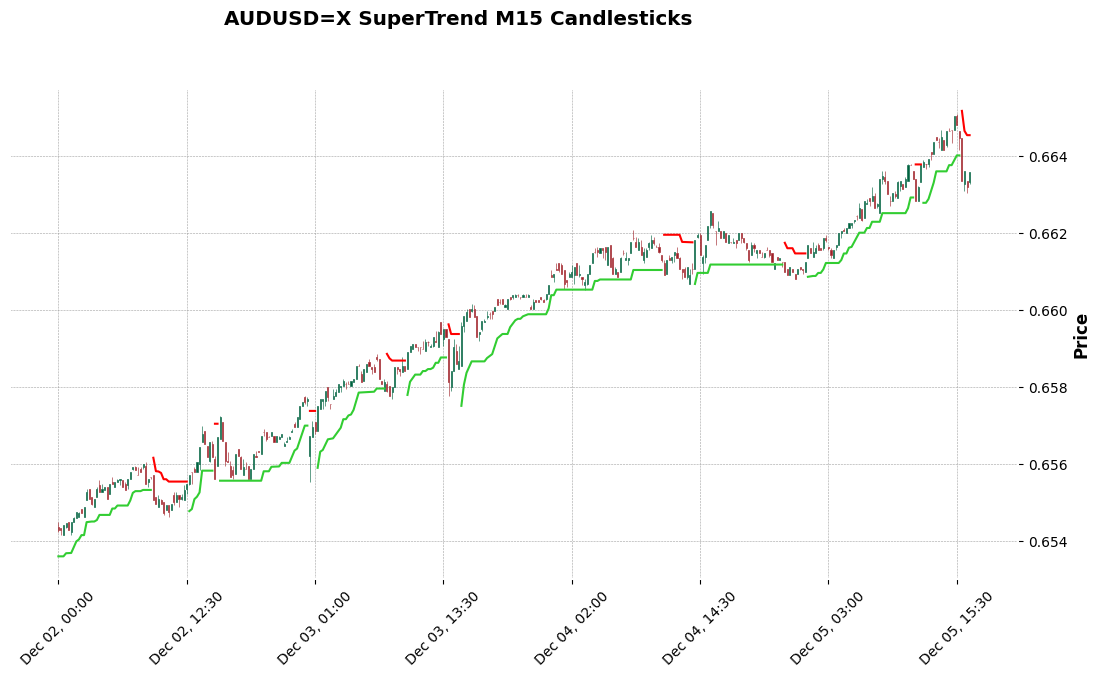

Signal count: 8 buys, 9 sells


In [21]:
import mplfinance as mpf
df_st = supertrend(df)

# Prepare candlestick data
df_candle = df_st[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df_candle.columns = ['open', 'high', 'low', 'close', 'volume']

# Create NaN-filled SuperTrend lines (SAFETY CHECKS)
df_st['up_plot'] = np.where(df_st['trend'] == 1, df_st['up'], np.nan)
df_st['dn_plot'] = np.where(df_st['trend'] == -1, df_st['dn'], np.nan)

# Buy/Sell signals with proper NaN handling
buy_signals = df_st['buy_signal'] * df_st['Low'] * 0.99
sell_signals = df_st['sell_signal'] * df_st['High'] * 1.01

# ONLY add plots if they have actual data (FIXES ERROR)
add_plots = [
    mpf.make_addplot(df_st['up_plot'], color='limegreen', width=1.5),
    mpf.make_addplot(df_st['dn_plot'], color='red', width=1.5)
]

# Add signals ONLY if they exist
if buy_signals.dropna().size > 0:
    add_plots.append(mpf.make_addplot(buy_signals, type='scatter', 
                                     markersize=100, marker='^', color='limegreen'))
if sell_signals.dropna().size > 0:
    add_plots.append(mpf.make_addplot(sell_signals, type='scatter', 
                                     markersize=100, marker='v', color='red'))

# Safe plot call
mpf.plot(df_candle, type='candle', style='charles', 
         title=f'{ticker} SuperTrend M15 Candlesticks',
         ylabel='Price', figsize=(14,7),
         addplot=add_plots,
         volume=False)  # Forex volume=0 anyway

print("Signal count:", df_st['buy_signal'].sum(), "buys,", df_st['sell_signal'].sum(), "sells")
